In [1]:
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import numpy as np 
import warnings
import optuna
warnings.filterwarnings('ignore')

from sklearn.metrics import mean_squared_error
from data_downloader import DataDownloader, ClimateDataCleaner, EconomicDataCleaner
from var_model import ClimateVAR
from sdice_model import SimplifiedDICE
from portfolio import PortfolioOptimizer

In [2]:
# Instancia para limpiar y procesar los datos climáticos
climate_cleaner = ClimateDataCleaner('Data/Temperature.csv', 'Data/Drought_Severity.csv', 'Data/CO2_Emissions.xlsx')
climate_data = climate_cleaner.clean_and_prepare_data()

# Instancia para limpiar y procesar los datos climáticos
economic_cleaner = EconomicDataCleaner('Data/GDP.csv', 'Data/TB3MS.csv', 'Data/CPI.csv')
economic_data = economic_cleaner.clean_and_prepare_data()

# Descarga los datos financieros
downloader = DataDownloader()
assets = ['AAPL', 'IBM', 'TSLA', 'GOOG', 'NVDA', 'NEE', 'FSLR', 'VWDRY', 'BEP'] 
benchmark = '^GSPC'  
start_date = '2014-11-01'
end_date = '2024-05-31'
rf = .065

asset_prices, benchmark_prices = downloader.download_data(start_date=start_date, 
                                                          end_date=end_date, 
                                                          assets=assets, 
                                                          benchmark=benchmark)

all_data = pd.merge(pd.merge(asset_prices, climate_data, on='Date'), economic_data, on='Date').iloc[:-1]
all_data.drop('Date', axis=1, inplace=True)

[*********************100%%**********************]  9 of 9 completed
[*********************100%%**********************]  1 of 1 completed


In [3]:
# Definir la función objetivo para Optuna
def objective(trial):
    # Elige el número de retardos entre 1 y 10
    maxlags = trial.suggest_int('maxlags', 1, 10)

    # Ajustar el modelo VAR con el número de retardos sugerido
    var_model = ClimateVAR(all_data)
    var_results = var_model.fit(maxlags=maxlags)

    # Realizar predicciones con el número de retardos sugerido
    predicted = var_model.predict(var_results, lags=maxlags, end=100)

    # Definir los valores reales (esto es solo un ejemplo, debes usar tus valores reales)
    actual = all_data[maxlags:100]  # Ajusta según la longitud de tus datos

    # Asegurarse de que predicted y actual tengan la misma longitud
    min_len = min(len(predicted), len(actual))
    predicted = predicted[:min_len]
    actual = actual[:min_len]

    # Calcular el error de predicción (RMSE)
    rmse = np.sqrt(mean_squared_error(actual, predicted))

    return rmse

# Crear el estudio de Optuna para minimizar el RMSE
study = optuna.create_study(direction='minimize')

# Ejecutar la optimización
study.optimize(objective, n_trials=100)

# Imprimir el número óptimo de retardos
print(f'Número óptimo de retardos: {study.best_trial.params["maxlags"]}')
print(f'RMSE óptimo: {study.best_value}')

# Ajustar el modelo VAR con el número óptimo de retardos
optimal_maxlags = study.best_trial.params["maxlags"]
var_model = ClimateVAR(all_data)
var_results = var_model.fit(maxlags=optimal_maxlags)

# Realizar predicción futura con el número óptimo de retardos
predict = var_model.predict(var_results, lags=optimal_maxlags, end=100)

# Imprimir los valores predichos
print("Valores predichos:")
print(predict)

[I 2024-09-20 21:49:51,488] A new study created in memory with name: no-name-93646c94-fb3f-4644-81ed-ad3eef53785b
[I 2024-09-20 21:49:51,494] Trial 0 finished with value: 42.67025670119204 and parameters: {'maxlags': 3}. Best is trial 0 with value: 42.67025670119204.
[I 2024-09-20 21:49:51,500] Trial 1 finished with value: 2.441185987218262e-09 and parameters: {'maxlags': 9}. Best is trial 1 with value: 2.441185987218262e-09.
[I 2024-09-20 21:49:51,519] Trial 2 finished with value: 2.739236708139724e-09 and parameters: {'maxlags': 10}. Best is trial 1 with value: 2.441185987218262e-09.
[I 2024-09-20 21:49:51,528] Trial 3 finished with value: 35.12378667229282 and parameters: {'maxlags': 4}. Best is trial 1 with value: 2.441185987218262e-09.
[I 2024-09-20 21:49:51,535] Trial 4 finished with value: 42.67025670119204 and parameters: {'maxlags': 3}. Best is trial 1 with value: 2.441185987218262e-09.
[I 2024-09-20 21:49:51,561] Trial 5 finished with value: 5.156210543978344e-09 and paramete

Número óptimo de retardos: 9
RMSE óptimo: 2.441185987218262e-09
Valores predichos:
[[-2.18162164e-02 -2.86220456e-02 -1.06396324e-01 ...  1.84016260e+04
   3.00000000e-02  2.38034000e+02]
 [ 8.34087066e-02 -4.03781199e-02  3.34970753e-01 ...  1.84351370e+04
   2.00000000e-02  2.37733000e+02]
 [-5.80440216e-03 -3.24411457e-02 -9.81253506e-03 ...  1.84351370e+04
   2.00000000e-02  2.37733000e+02]
 ...
 [ 2.31828745e-02 -9.24476064e-02 -4.76351713e-02 ...  2.68136010e+04
   4.54000000e+00  3.00356000e+02]
 [ 1.18648867e-01  2.06355232e-01  2.85916997e-01 ...  2.68136010e+04
   4.54000000e+00  3.00356000e+02]
 [ 2.89871670e-02 -1.61853325e-02 -1.60551716e-01 ...  2.70630120e+04
   4.92000000e+00  3.03032000e+02]]


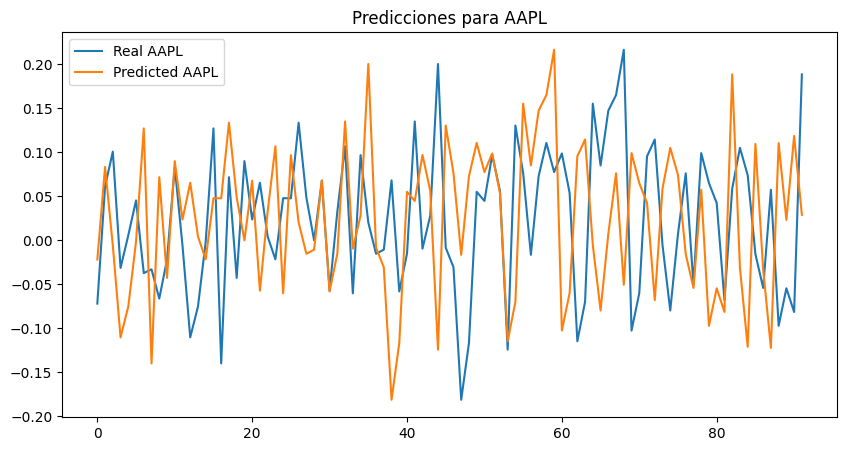

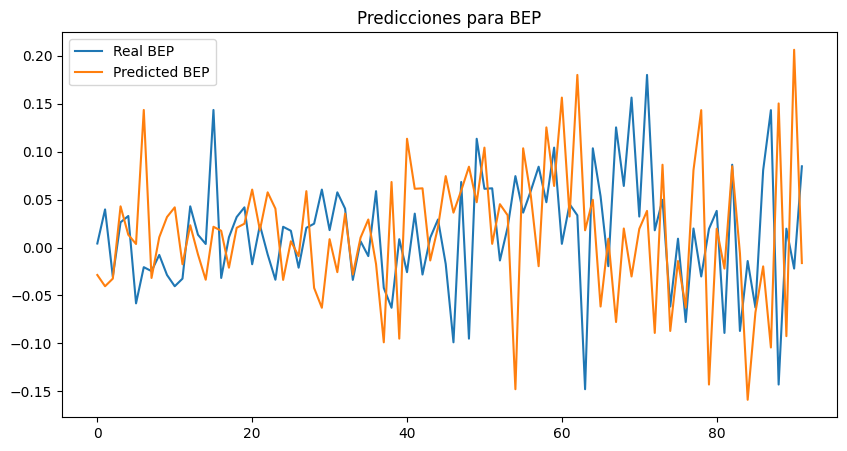

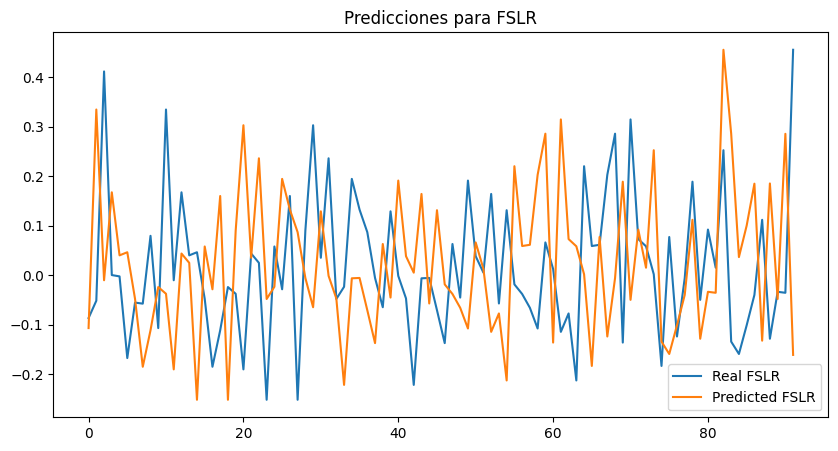

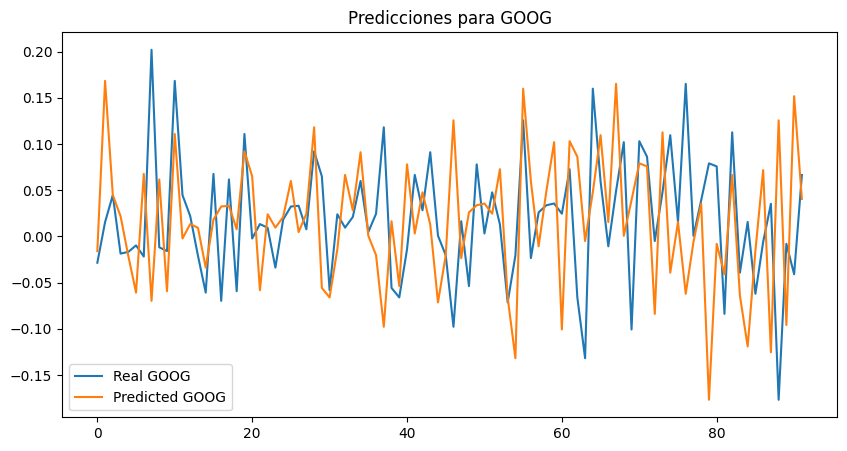

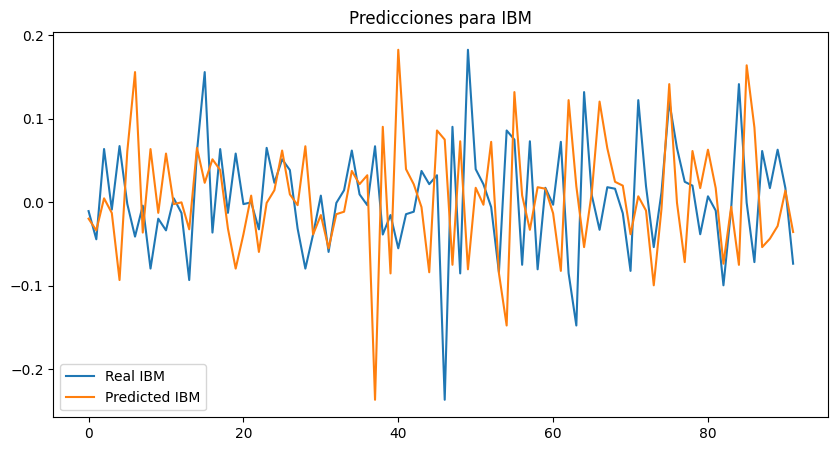

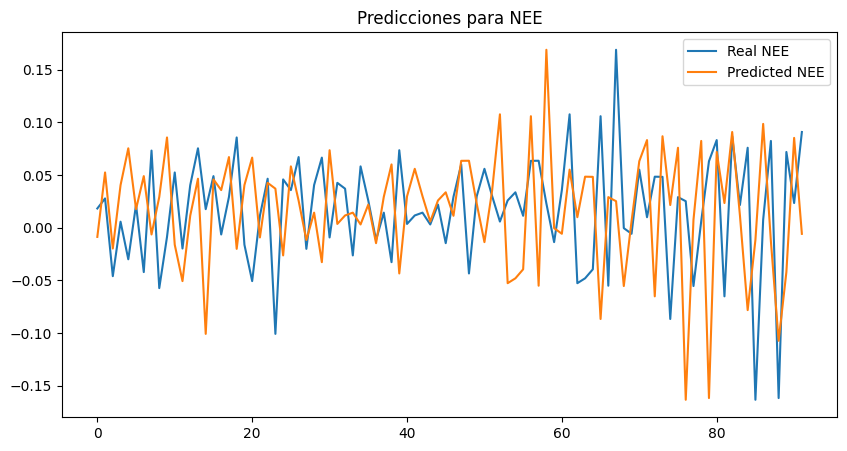

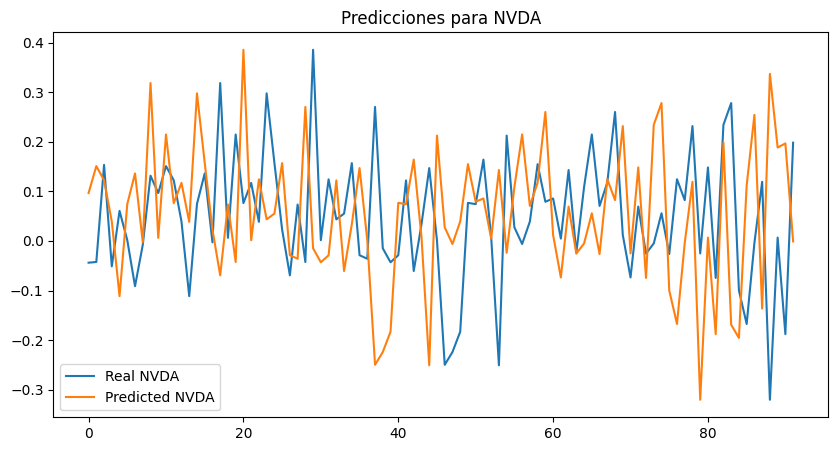

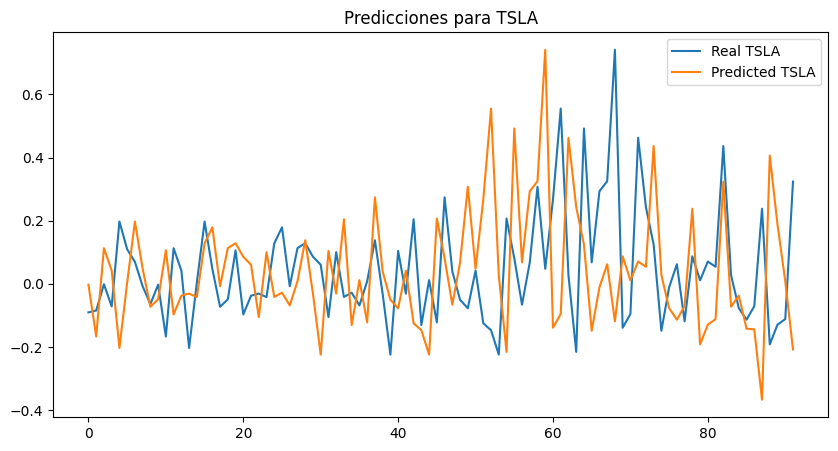

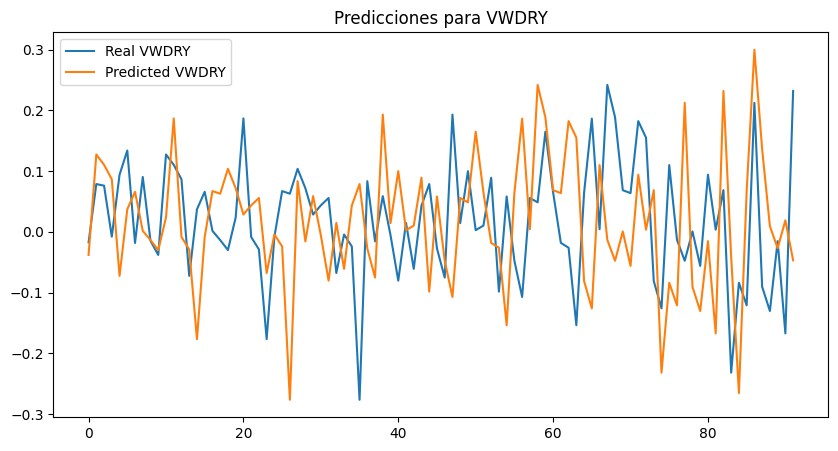

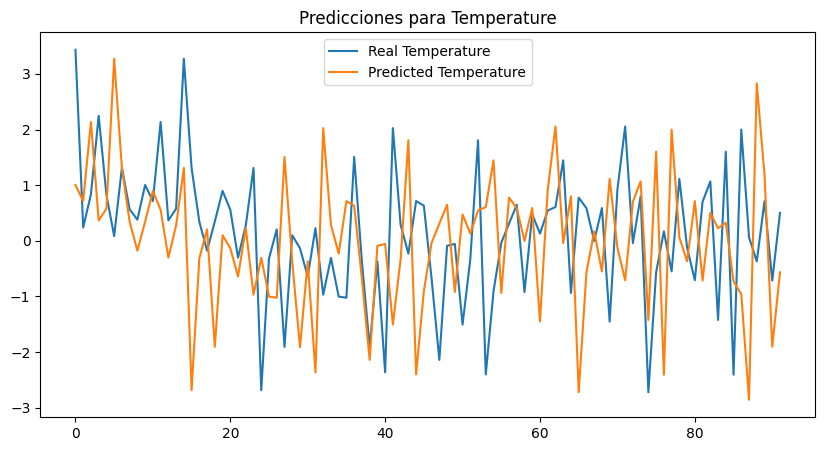

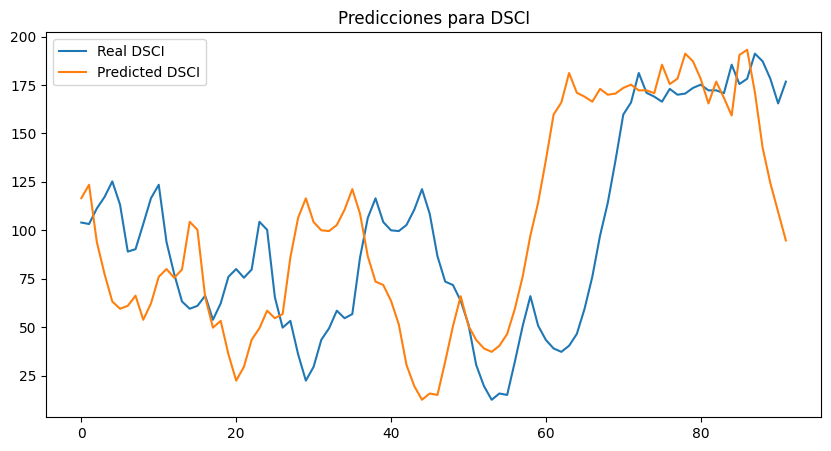

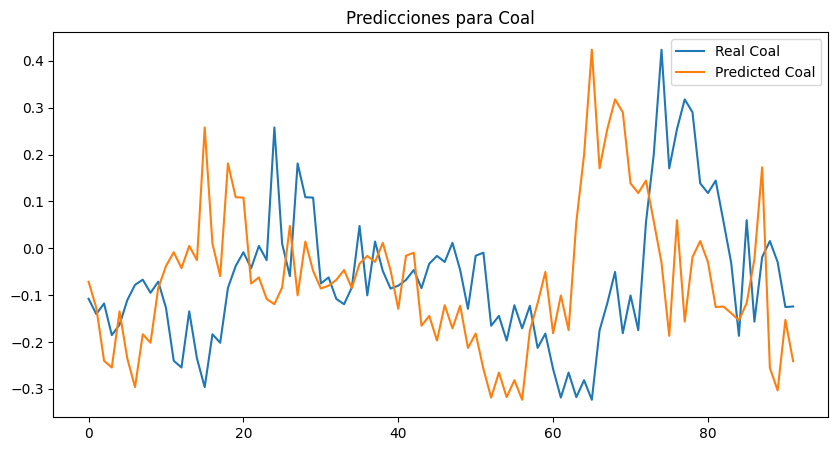

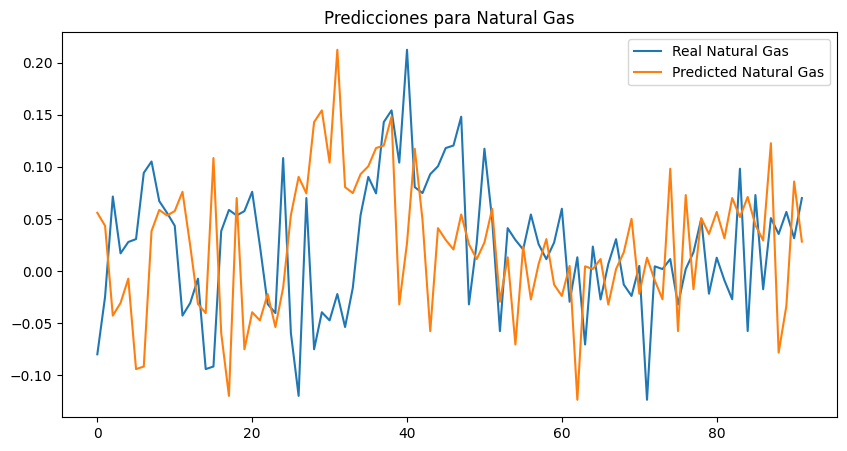

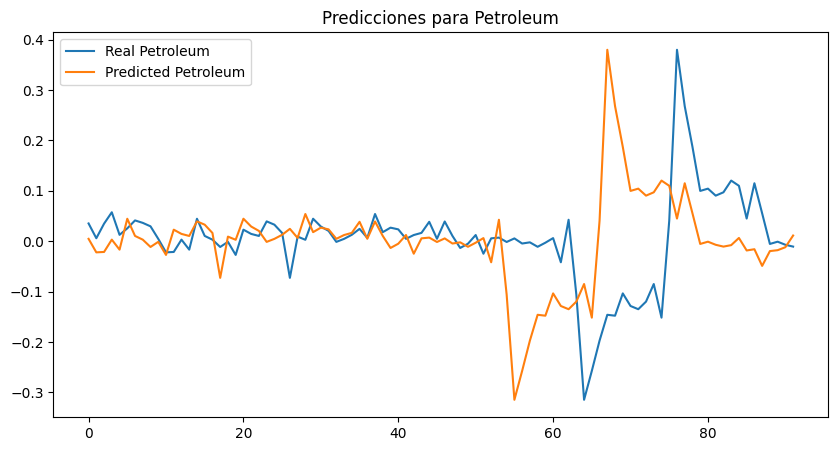

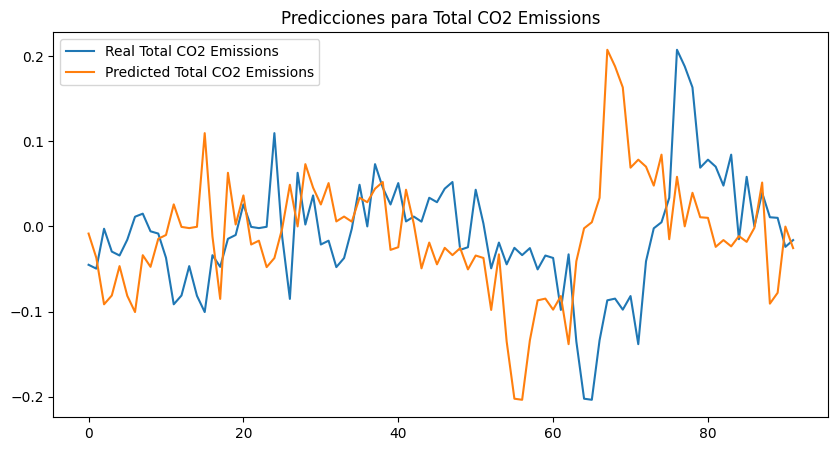

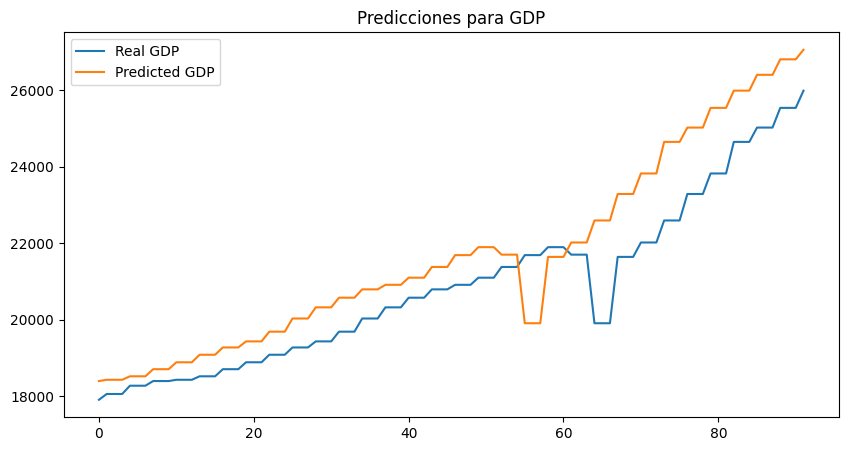

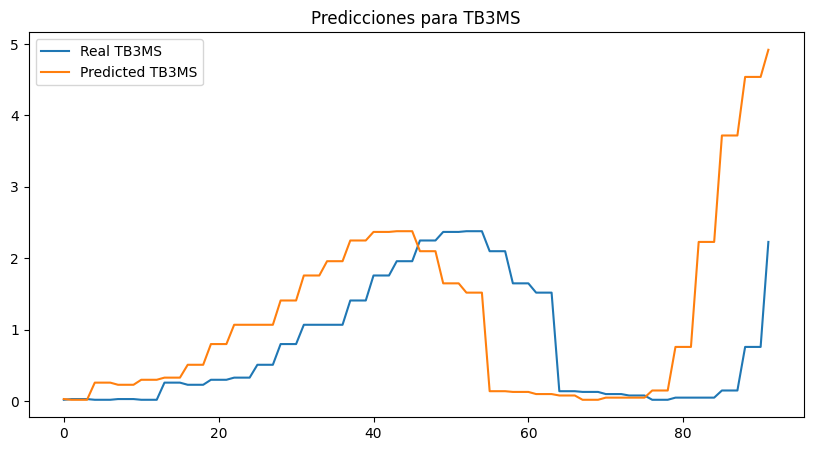

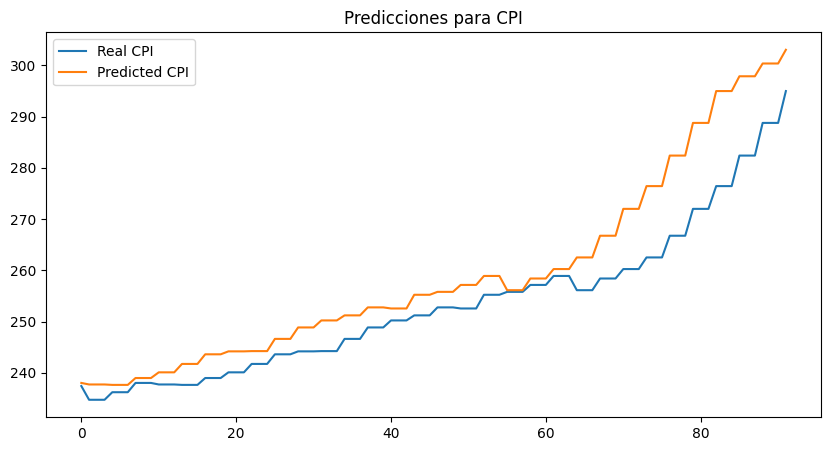

In [4]:
# Graficar las predicciones versus los datos originales
for i, column in enumerate(all_data.columns):
    plt.figure(figsize=(10, 5))
    plt.plot(all_data.index[:len(predict)], all_data.iloc[:len(predict), i], label=f"Real {column}")
    plt.plot(all_data.index[:len(predict)], predict[:, i], label=f"Predicted {column}")
    plt.title(f"Predicciones para {column}")
    plt.legend()
    plt.show()

Pesos óptimos del portafolio: [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.91533523e-12
 0.00000000e+00 6.30145951e-01 2.96891694e-01 0.00000000e+00
 0.00000000e+00 3.68119020e-02 0.00000000e+00 0.00000000e+00
 1.38984541e-14 0.00000000e+00 0.00000000e+00 1.39045233e-14
 0.00000000e+00 3.61504531e-02]


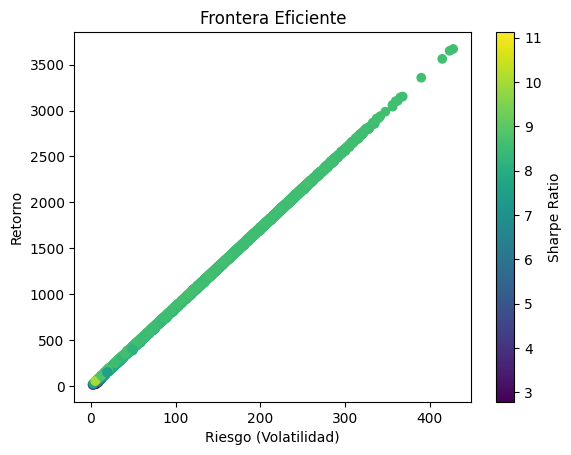

In [6]:
# Implementación para la generación de portafolios
def generate_portfolios_with_climate_and_economic_data(all_data, expected_returns, cov_matrix, risk_free_rate):
    """
    Genera portafolios utilizando datos financieros, climáticos y económicos,
    y optimiza el portafolio basado en el ratio de Sharpe.
    
    :param all_data: DataFrame con todos los datos combinados (financieros, climáticos y económicos).
    :param expected_returns: Retornos esperados de los activos financieros.
    :param cov_matrix: Matriz de covarianzas de los activos financieros.
    :param risk_free_rate: Tasa libre de riesgo.
    :return: Pesos óptimos y la gráfica de la frontera eficiente.
    """
    # Inicializar optimizador de portafolios
    optimizer = PortfolioOptimizer(expected_returns, cov_matrix, risk_free_rate)
    
    # Optimizar el portafolio para maximizar el Sharpe Ratio
    optimal_weights = optimizer.optimize_portfolio()
    print("Pesos óptimos del portafolio:", optimal_weights)
    
    # Graficar la frontera eficiente
    optimizer.plot_efficient_frontier(num_portfolios=5000)
    
    return optimal_weights


risk_free_rate = 0.065  # Tasa libre de riesgo ajustable
expected_returns = np.mean(predict, axis=0)  # Calculado de las predicciones del VAR
cov_matrix = np.cov(predict, rowvar=False)   # Matriz de covarianza de las predicciones

# Generación de portafolios y optimización
optimal_weights = generate_portfolios_with_climate_and_economic_data(all_data, expected_returns, cov_matrix, risk_free_rate)
